In [1]:
# %%
# Step 1: Interactive AOI selection in Jupyter
from ipyleaflet import Map, DrawControl
from IPython.display import display, clear_output

# Variable to store coordinates
geometry_coords = []

def handle_draw(target, action, geo_json):
    global geometry_coords
    geometry_coords = geo_json['geometry']['coordinates']
    clear_output(wait=True)
    print("Geometry coordinates acquired:")
    print(geometry_coords)
    print("\nProceed to the next cell to run the download script using this AOI.")

# Center map roughly on area of interest
center = (44.92, 12.63)
m = Map(center=center, zoom=10)

draw_control = DrawControl(
    polygon={"shapeOptions": {"color": "blue", "fillOpacity": 0.2}},
    rectangle={}, polyline={}, circle={}, circlemarker={}, marker={}
)
draw_control.on_draw(handle_draw)

m.add_control(draw_control)
display(m)

# %%


Map(center=[44.92, 12.63], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [5]:
# %%
# Cell 1: Compute threshold and identify first exceedance date
import datetime
import xarray as xr
import pandas as pd
import gc
from pyextremes import EVA

# Load discharge series 2018-2023
lat_point= 47.21
long_point= -1.54
files = [
    "/home/michelangelo/data_discharge_2018.grib",
    "/home/michelangelo/data_discharge_2019.grib",
    "/home/michelangelo/data_discharge_2020.grib",
    "/home/michelangelo/data_discharge_2021.grib",
    "/home/michelangelo/data_discharge_2022.grib",
    "/home/michelangelo/data_discharge_2023.grib2",
]
ser_list = []
import xarray as xr
for f in files:
    ds = xr.open_dataset(f, engine="cfgrib", filter_by_keys={"shortName": "dis24"})
    pt = ds.sel(latitude=lat_point, longitude=lon_point, method="nearest")
    s = pt["dis24"].to_series().dropna().asfreq("D")
    ser_list.append(s)
    ds.close(); gc.collect()

discharge = pd.concat(ser_list)
discharge = discharge[~discharge.index.duplicated()].sort_index()

# Fit EVA model and extract threshold
model = EVA(discharge)
model.get_extremes(method="BM", block_size=pd.Timedelta(days=30))
model.fit_model()
summary = model.get_summary(return_period=[1], alpha=0.95, n_samples=12)
threshold = float(summary.loc[1, 'return value'])
print(f"Computed threshold (TR=1a): {threshold:.2f}")

# Identify first exceedance date in 2023
exceed_dates = discharge['2023'].loc[discharge['2023'] > threshold].index
if exceed_dates.empty:
    print("No threshold exceedance in 2023. Nothing to download.")
    event_date = None
else:
    event_date = exceed_dates[0]
    print(f"First threshold exceedance on: {event_date.date()}")

# %%


/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/michelangelo/data_discharge_2019.grib.47d85.idx' older than GRIB file
/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_time

Computed threshold (TR=1a): 4557.84
First threshold exceedance on: 2023-11-03


In [12]:


# %%
# %%
# Cell 2: Download Sentinel-2 images around event_date
import ee
import datetime
from ee import batch

# Initialize Earth Engine
ee.Initialize()

# Exit if no event_date
if event_date is None:
    raise SystemExit("No event date. Aborting downloads.")

# Define AOI geometry (use geometry_coords from Cell 1 context)
ggeometry = ee.Geometry.Polygon(geometry_coords)

# Reference projection for export
sample = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(ggeometry).first()
proj = sample.select("B2").projection().getInfo()

drive_folder = "/home/michelangelo/mnt/gdrivemichi/sentinel"
# Offsets: 10 days before to 10 days after
offsets = list(range(-10, 11))  # -10, ..., 0, ..., +10

print(f"Downloading images for event {event_date.date()} with +/-10 days")
for off in offsets:
    target = event_date + datetime.timedelta(days=off)
    next_day = target + datetime.timedelta(days=1)
    coll = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
            .filterDate(target.strftime("%Y-%m-%d"), next_day.strftime("%Y-%m-%d"))
            .filterBounds(ggeometry)
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 40)))
    best = coll.sort("CLOUDY_PIXEL_PERCENTAGE").first()
    info = best.getInfo()
    if info and 'id' in info:
        img = best.select([
            'B1','B2','B3','B4','B5','B6',
            'B7','B8','B8A','B9','B11','B12'
        ]).clip(ggeometry)
        # Use target date formatted as YYYY_MM_DD for description and filename
        date_str = target.strftime('%Y_%m_%d')
        task = batch.Export.image.toDrive(
            image=img,
            description=date_str,
            folder=drive_folder,
            fileNamePrefix=date_str,
            fileFormat='GeoTIFF',  # ensure TIFF format
            region=ggeometry,
            crs=proj['crs'],
            crsTransform=proj['transform'],
            maxPixels=1e13
        )
        task.start()
        print(f"  ✔ Offset {off:+d}: downloaded for {target.date()} as {date_str}.tif")
    else:
        print(f"  – Offset {off:+d}: no valid scene on {target.date()}")

print("Download block completed.")




  – Offset -10: no valid scene on 2023-10-24
  – Offset -9: no valid scene on 2023-10-25
  – Offset -8: no valid scene on 2023-10-26
  ✔ Offset -7: downloaded for 2023-10-27 as 2023_10_27.tif
  – Offset -6: no valid scene on 2023-10-28
  – Offset -5: no valid scene on 2023-10-29
  – Offset -4: no valid scene on 2023-10-30
  – Offset -3: no valid scene on 2023-10-31
  – Offset -2: no valid scene on 2023-11-01
  – Offset -1: no valid scene on 2023-11-02
  – Offset +0: no valid scene on 2023-11-03
  ✔ Offset +1: downloaded for 2023-11-04 as 2023_11_04.tif
  – Offset +2: no valid scene on 2023-11-05
  – Offset +3: no valid scene on 2023-11-06
  – Offset +4: no valid scene on 2023-11-07
  – Offset +5: no valid scene on 2023-11-08
  – Offset +6: no valid scene on 2023-11-09
  – Offset +7: no valid scene on 2023-11-10
  ✔ Offset +8: downloaded for 2023-11-11 as 2023_11_11.tif
  – Offset +9: no valid scene on 2023-11-12
  – Offset +10: no valid scene on 2023-11-13
Download block completed.


In [ ]:
#Discharges e block maxima method
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import EVA
import gc

# Prova ad importare dask per abilitare il chunking
try:
    import dask  # Se dask è installato, abilitiamo il chunking
    use_chunks = True
    print("Dask rilevato: utilizzo del chunking abilitato.")
except ImportError:
    print("Dask non installato. Installalo con 'pip install dask' per ridurre il consumo di memoria.")
    use_chunks = False

# Specifica del punto (longitude, latitude)
lon_point = 114.88
lat_point = 35.144

# Lista dei file GRIB2 per ciascun anno
file_list = [
    "/home/michelangelo/data_discharge_2018.grib",
    "/home/michelangelo/data_discharge_2019.grib",
    "/home/michelangelo/data_discharge_2020.grib",
    "/home/michelangelo/data_discharge_2021.grib",
    "/home/michelangelo/data_discharge_2022.grib",
    "/home/michelangelo/data_discharge_2023.grib2",
]

# Lista per contenere le serie temporali
series_list = []

for file in file_list:
    if use_chunks:
        ds = xr.open_dataset(
            file,
            engine="cfgrib",
            filter_by_keys={"shortName": "dis24"},
            chunks={"time": 100}  # Specifica un chunk adeguato per la dimensione temporale
        )
    else:
        ds = xr.open_dataset(
            file,
            engine="cfgrib",
            filter_by_keys={"shortName": "dis24"}
        )
    
    # Seleziona il punto più vicino
    ds_point = ds.sel(latitude=lat_point, longitude=lon_point, method="nearest")
    # Estrai la serie temporale per il punto
    discharge_da = ds_point["dis24"]
    # Converti in pandas Series: questo computa solo il punto, riducendo il carico in memoria
    discharge_series = discharge_da.to_series().dropna().asfreq('D')
    series_list.append(discharge_series)
    
    # Chiudi il dataset e libera la memoria
    ds.close()
    gc.collect()

# Unisci le serie in un'unica serie temporale
discharge_series_full = pd.concat(series_list)
# Rimuove eventuali duplicati nell'indice e ordina la serie
discharge_series_full = discharge_series_full[~discharge_series_full.index.duplicated(keep='first')]
discharge_series_full = discharge_series_full.sort_index()

# Visualizza la serie combinata
plt.figure(figsize=(10, 6))
discharge_series_full.plot()
plt.title("Mean Discharge at Point [{}, {}]".format(lon_point, lat_point))
plt.xlabel("Time")
plt.ylabel("Discharge")
plt.show()


model = EVA(discharge_series_full)

model.get_extremes(method="BM", block_size=pd.Timedelta(days=30))


model.plot_extremes()


model.fit_model()


summary = model.get_summary(
    return_period=[1],
    alpha=0.95,
    n_samples=12,
)
print(summary)


model.plot_diagnostic(alpha=0.95)

In [ ]:
#Discharges
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


ds = xr.open_dataset(
    "/home/michelangelo/data_discharge_2023.grib2",
    engine="cfgrib",
    filter_by_keys={"shortName": "dis24"}
)




ds_point = ds.sel(
    latitude=lat_point,
    longitude=lon_point,
    method="nearest"
)
discharge_series = (
    ds_point["dis24"]
      .to_series()
      .dropna()
      .asfreq("D")
)


threshold = 5556.482394
exceed = discharge_series[discharge_series > threshold]
first_date = exceed.index[0] if not exceed.empty else None


if first_date is not None:
    print(f"Threshold exceeded on: {first_date.date()}")
else:
    print("Threshold not exceeded in 2023.")


plt.figure(figsize=(10, 5), dpi=100)
discharge_series.plot(label="Discharge")
plt.axhline(
    threshold,
    color="red",
    linestyle="--",
    label=f"Threshold = {threshold:.2f}"
)
if first_date is not None:
    plt.axvline(
        first_date,
        color="orange",
        linestyle=":",
        label=f"First exceedance: {first_date.date()}"
    )
plt.title(f"Mean Discharge at [{lon_point}, {lat_point}] (2023)")
plt.xlabel("Date")
plt.ylabel("Discharge")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#Time series of Sentinel-2 images
import ee
import datetime
ee.Initialize()



geometry = ee.Geometry.Polygon([
[12.271729, 44.740881],
[12.271729, 45.106485],
[12.98584,  45.106485],
[12.98584,  44.740881],
[12.271729, 44.740881]
])
start_date    = datetime.date(2023, 10, 30)
end_date      = datetime.date(2023, 12, 31)
max_cloud_pct = 40

# 3) Proiezione di esempio per CRS e transform

sample = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          .filterBounds(geometry)
          .first())
proj = sample.select('B2').projection().getInfo()
drive_folder  = "/home/michelangelo/mnt/gdrivemichi/sentinel"
# 5) Loop giorno per giorno

current = start_date
while current <= end_date:

 next_day = current + datetime.timedelta(days=1)
 day_str  = current.strftime('%Y-%m-%d')


coll = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterDate(day_str, next_day.strftime('%Y-%m-%d'))
        .filterBounds(geometry)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_pct))
       )
best = coll.sort('CLOUDY_PIXEL_PERCENTAGE').first()
info = best.getInfo()

if info and 'id' in info:
    date  = ee.Date(best.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    cloud = int(best.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())
    desc  = f"sentinel_{date}_{cloud}pct"
    sentinel = best.select([
        'B1','B2','B3','B4','B5','B6',
        'B7','B8','B8A','B9','B11','B12'
    ])

   
    task = ee.batch.Export.image.toDrive(
        image=sentinel,
        description=desc,
        folder="/home/michelangelo/mnt/gdrivemichi",                                  # export root di My Drive
        fileNamePrefix=f"Sentinel_PO/{desc}",  # crea My Drive/thesis_sentinel2/desc.tif
        region=geometry,
        crs=proj['crs'],
        crsTransform=proj['transform'],
        maxPixels=1e13
    )
    task.start()
    print(f"✔ Task creato: {desc} (ID: {task.id})")
else:
    print(f"– Nessuna scena valida per il {day_str}")


    current = next_day 



In [9]:
import glob
import rasterio
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 1) Pattern corretto con wildcard e slash normali
tif_pattern = "/home/michelangelo/Pictures/Sentinel_images_PO_river"
tif_files = sorted(glob.glob(tif_pattern))

# Verifica che il pattern trovi qualcosa
print(f"Ho trovato {len(tif_files)} file TIFF:")
for f in tif_files:
    print(" ", f)

for tif in tif_files:
    # 2) Apri il GeoTIFF
    with rasterio.open(tif) as src:
        # Banda 4 = Red, 3 = Green, 2 = Blue
        red   = src.read(4)
        green = src.read(3)
        blue  = src.read(2)

    # 3) Crea l’array RGB (senza scaling)
    rgb = np.dstack((red, green, blue))

    # 4) Visualizza
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb)
    plt.title(tif.split('/')[-1])
    plt.axis('off')
    plt.show()



Ho trovato 1 file TIFF:
  /home/michelangelo/Pictures/Sentinel_images_PO_river


RasterioIOError: '/home/michelangelo/Pictures/Sentinel_images_PO_river' not recognized as a supported file format.

In [16]:
#First tryial unet ++1
import os
import numpy as np
import rasterio
import torch
from tqdm import tqdm
from marinedebrisdetector.main_cli import MarineDebrisDetector

@torch.no_grad()
def sliding_window_inference(image_path, detector, tile_size=256, stride=64, device="cuda"):
    with rasterio.open(image_path) as src:
        img = src.read()  # (bands, H, W)
        profile = src.profile
        h, w = img.shape[1], img.shape[2]

   
    img = img.astype(np.float32) / 10000.0


    pred_sum = np.zeros((h, w), dtype=np.float32)
    pred_count = np.zeros((h, w), dtype=np.float32)

    # Sliding window
    for y in tqdm(range(0, h - tile_size + 1, stride), desc="Sliding"):
        for x in range(0, w - tile_size + 1, stride):
            patch = img[:, y:y+tile_size, x:x+tile_size]
            input_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)  # (1, C, H, W)

            score, _ = detector(input_tensor)
            pred = score.squeeze().cpu().numpy()  # (H, W)

            pred_sum[y:y+tile_size, x:x+tile_size] += pred
            pred_count[y:y+tile_size, x:x+tile_size] += 1

    # Mean 
    final_pred = pred_sum / (pred_count + 1e-8)
    return final_pred, profile


In [14]:
# model
class Args:
    def __init__(self):
        self.model = "unet++"
        self.device = "cuda"
        self.ensemble = False
        self.test_time_augmentation = False
        self.pretrained = False
        self.model_path = None
        self.seed = "1"

args = Args()
detector = MarineDebrisDetector(args)
detector.model.eval().to(args.device)

# Input/Output
image_path = "/home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-12-16_PO.tif"
output_path = image_path.replace(".tif", "_sliding_prediction.tif")

# Inference sliding window
pred, profile = sliding_window_inference(image_path, detector, tile_size=256, stride=64, device="cuda")


profile.update({
    "count": 1,
    "dtype": "float32",
    "height": pred.shape[0],
    "width": pred.shape[1]
})

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(pred.astype(np.float32), 1)

print(f"✅ Predizione salvata in: {output_path}")




Loading weights from: /home/michelangelo/marinedebrisdetector/marinedebrisdetector/data/unet++1/epoch=54-val_loss=0.50-auroc=0.987.ckpt


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-12-16_PO_sliding_prediction.tif


In [18]:
import glob
class Args:
    def __init__(self):
        self.model = "unet++"
        self.device = "cuda"
        self.ensemble = False
        self.test_time_augmentation = False
        self.pretrained = False
        self.model_path = None
        self.seed = "1"

args = Args()
detector = MarineDebrisDetector(args)
detector.model.eval().to(args.device)

# Cartella immagini
folder = "/home/michelangelo/Pictures/Sentinel_images_PO_river"
tif_paths = sorted(glob.glob(os.path.join(folder, "*.tif")))
tif_paths = [p for p in tif_paths if not p.endswith("_prediction.tif") and not p.endswith("_sliding_prediction.tif")]

# Loop su tutte le immagini
for image_path in tif_paths:
    print(f"\n🚀 Inizio inferenza su: {image_path}")
    pred, profile = sliding_window_inference(image_path, detector, tile_size=256, stride=64, device="cuda")

    output_path = image_path.replace(".tif", "_sliding_prediction.tif")

    profile.update({
        "count": 1,
        "dtype": "float32",
        "height": pred.shape[0],
        "width": pred.shape[1]
    })

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(pred.astype(np.float32), 1)

    print(f"✅ Predizione salvata in: {output_path}")

Loading weights from: /home/michelangelo/marinedebrisdetector/marinedebrisdetector/data/unet++1/epoch=54-val_loss=0.50-auroc=0.987.ckpt

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-06-29_2_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-06-29_2_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-07-02_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-07-02_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-10-02_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-10-02_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-10-07_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-10-07_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-11-04_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-11-04_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-11-11_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-11-11_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-11-26_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-11-26_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-12-16_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-12-16_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-12-24_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-12-24_PO_sliding_prediction.tif


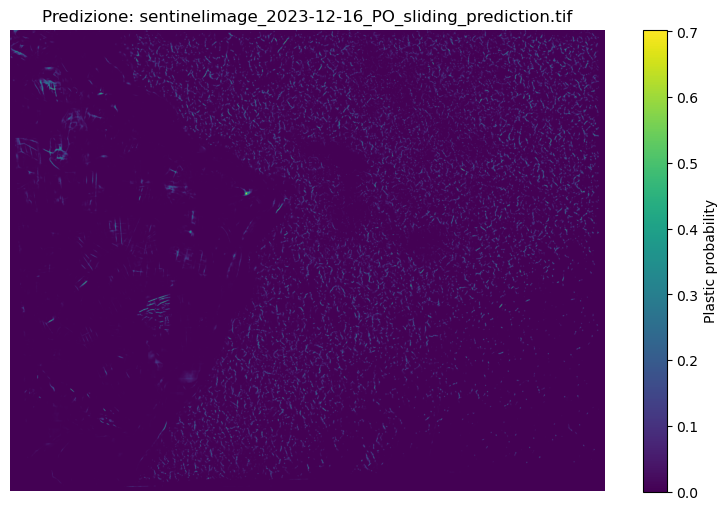

In [15]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# 📍 Specifica il percorso del file da visualizzare
pred_path = "/home/michelangelo/Pictures/Sentinel_images_PO_river/sentinelimage_2023-12-16_PO_sliding_prediction.tif"

# 🖼️ Caricamento e visualizzazione
with rasterio.open(pred_path) as src:
    pred = src.read(1)  # primo canale

plt.figure(figsize=(10, 6))
plt.imshow(pred, cmap="viridis")
plt.colorbar(label="Plastic")
plt.title(f"Predizione: {pred_path.split('/')[-1]}")
plt.axis("off")
plt.show()


Intervallo globale (grezzo): vmin=0.0000, vmax=0.7867


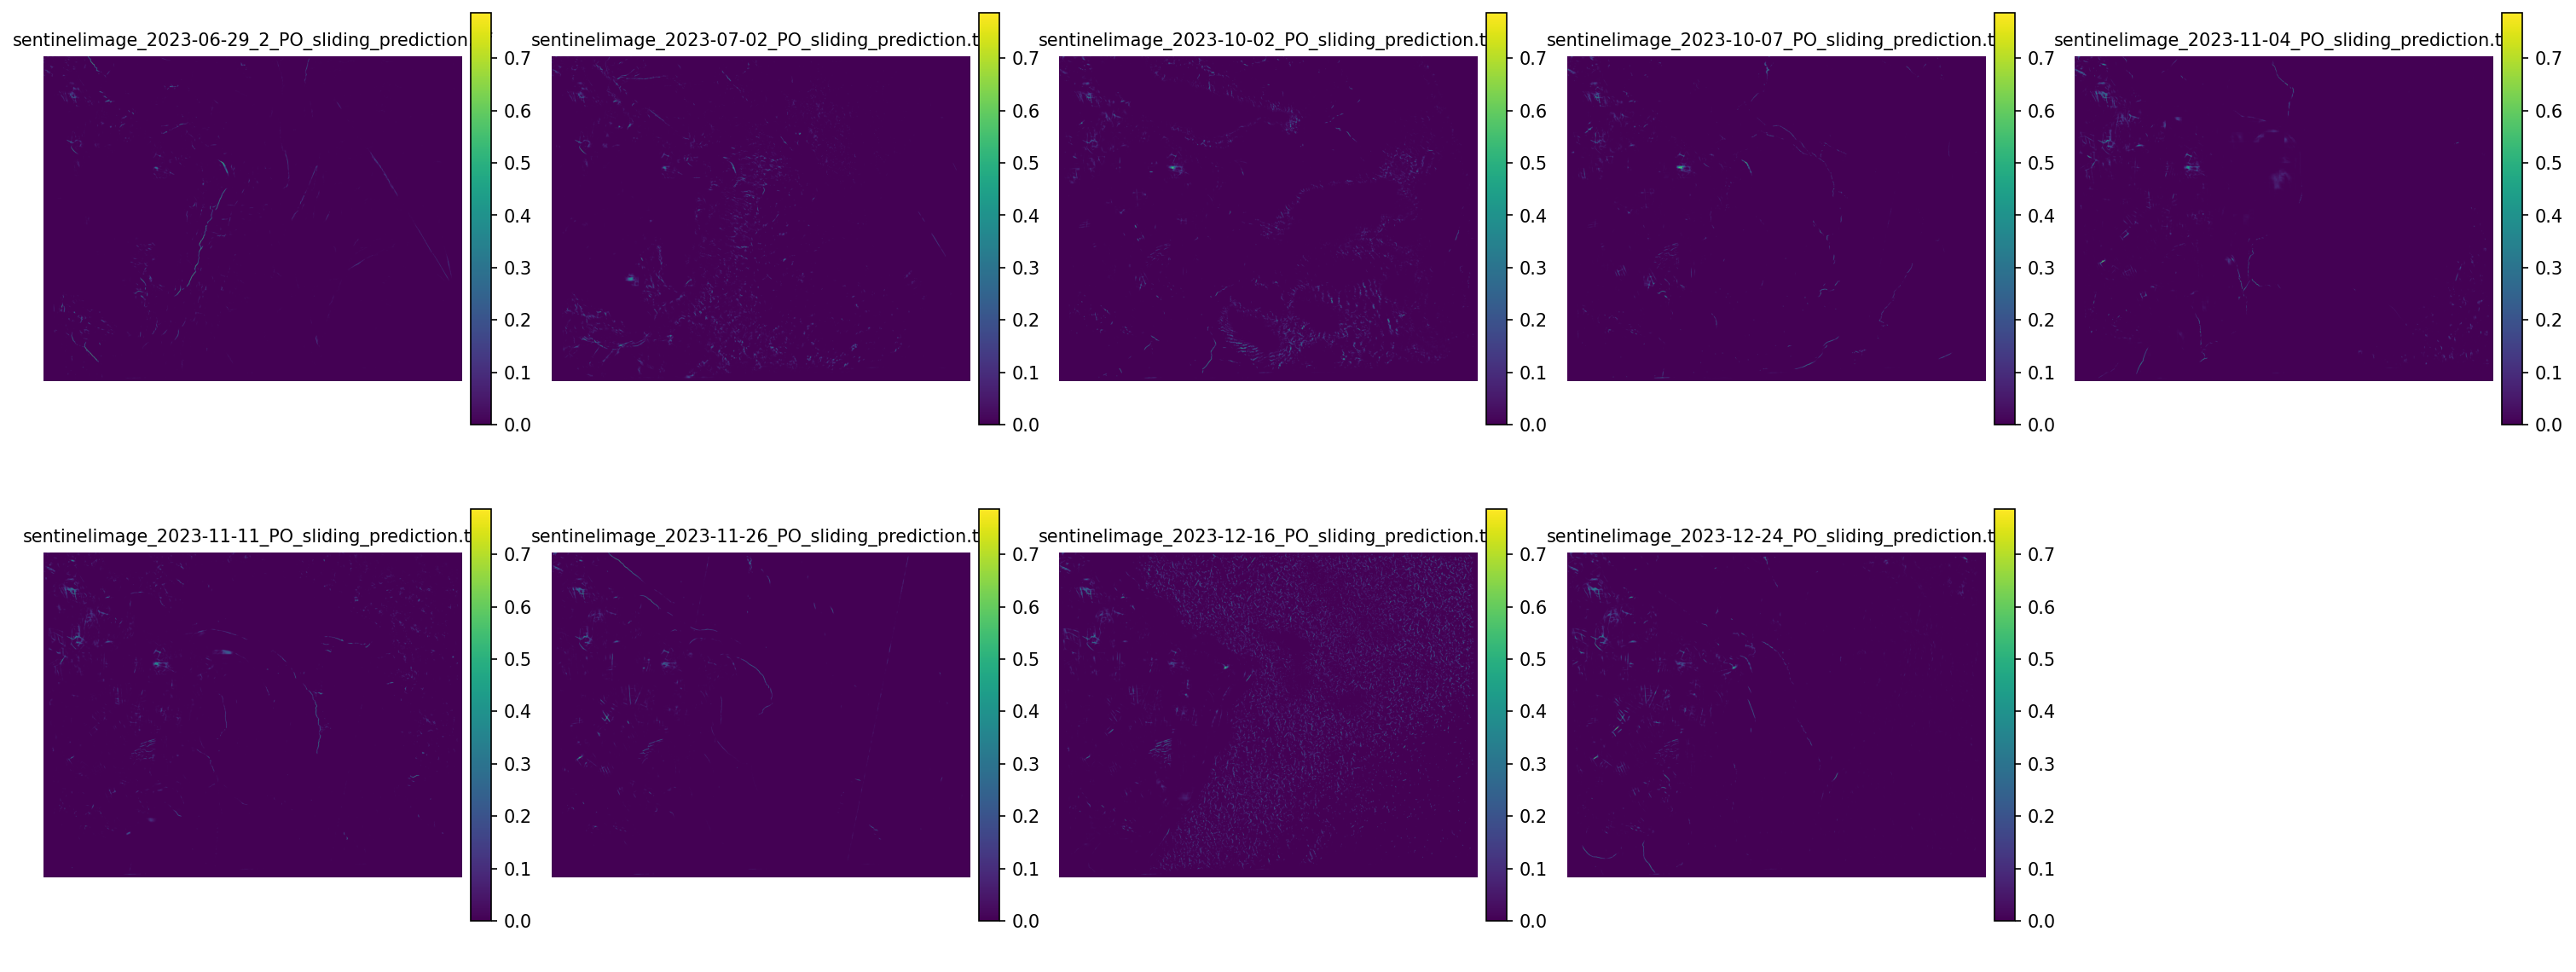

In [20]:
#Activation map non nonrmalizzate unet++
import os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Cartella con i .tif di prediction
folder = "/home/michelangelo/Pictures/Sentinel_images_PO_river"
prediction_paths = sorted(glob.glob(os.path.join(folder, "*_prediction.tif")))

# Carica le immagini senza normalizzazione
images = []
for p in prediction_paths:
    with rasterio.open(p) as src:
        img = src.read(1).astype(np.float32)
    images.append(img)

# Trova vmin e vmax globali sui valori grezzi
vmin = min(img.min() for img in images)
vmax = max(img.max() for img in images)
print(f"Intervallo globale (grezzo): vmin={vmin:.4f}, vmax={vmax:.4f}")

# Impostazioni griglia
n = len(images)
ncols = 5
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), dpi=150)
axes = axes.flatten()

# Plot con colorbar individuale
for ax, img, path in zip(axes, images, prediction_paths):
    im = ax.imshow(img, vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(os.path.basename(path), fontsize=10)
    ax.axis('off')
    # Colorbar accanto a ogni immagine
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.02)

# Rimuovi eventuali assi extra
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()



\ treshold: 0.0876



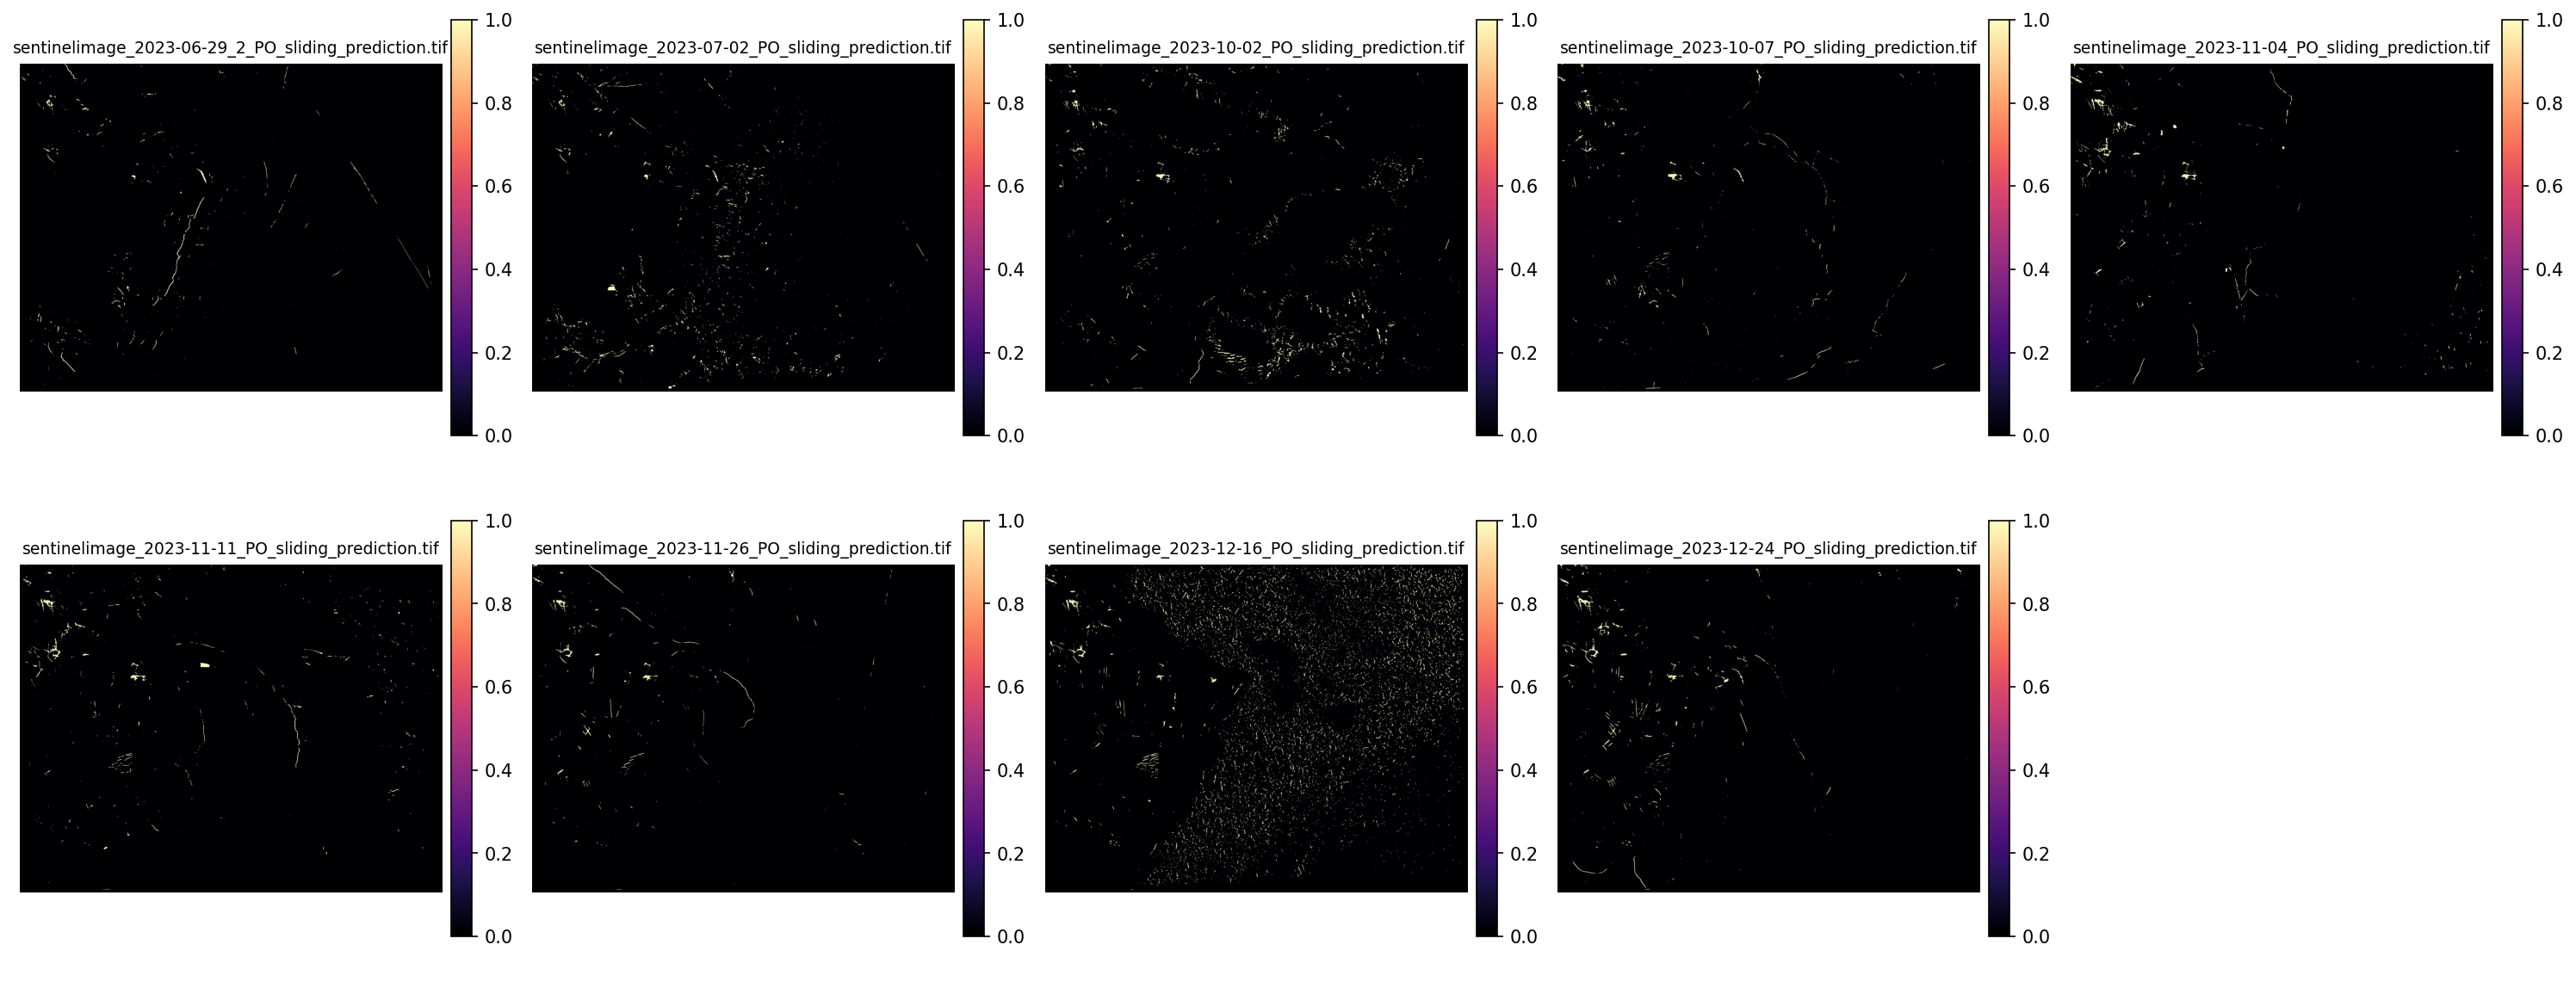

In [24]:
# Activation maps binarizedm unet++
import os
import glob
import rasterio
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt


folder = "/home/michelangelo/Pictures/Sentinel_images_PO_river"
prediction_paths = sorted(glob.glob(os.path.join(folder, "*_prediction.tif")))


all_pixels = []
for path in prediction_paths:
    with rasterio.open(path) as src:
        img = src.read(1).astype(np.float32)
    all_pixels.append(img.flatten())
all_pixels = np.concatenate(all_pixels)


global_thr = threshold_otsu(all_pixels)
print(f"\ treshold: {global_thr:.4f}\n")

binary_images = []
filenames = []
for path in prediction_paths:
    with rasterio.open(path) as src:
        img = src.read(1).astype(np.float32)
    bin_img = (img > global_thr).astype(np.uint8)
    binary_images.append(bin_img)
    filenames.append(os.path.basename(path))


n = len(binary_images)
ncols = 5
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), dpi=150)
axes = axes.flatten()

for ax, bin_img, fname in zip(axes, binary_images, filenames):
    im = ax.imshow(bin_img, cmap="magma", vmin=0, vmax=1)
    ax.set_title(fname, fontsize=9)
    ax.axis("off")
    fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.02)


for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()



Trovati 9 file pred.
Stack shape: (4069, 5238, 9) (H, W, T)


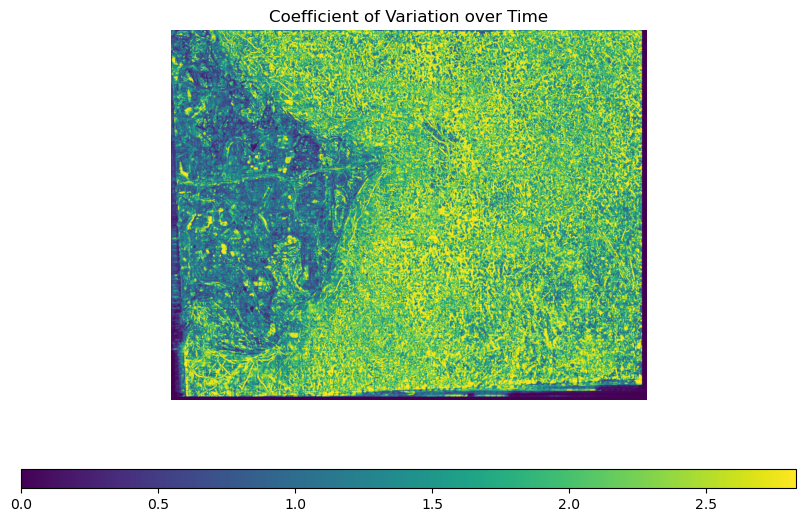

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob

input_folder = "/home/michelangelo/Pictures/Sentinel_images_PO_river"  
file_paths = sorted(glob.glob(os.path.join(input_folder, "*_prediction.tif")))

print(f"Trovati {len(file_paths)} file pred.")
assert len(file_paths) > 0, "⚠️ Nessun file *_prediction.tif trovato!"


stack = np.stack([rasterio.open(f).read(1) for f in file_paths], axis=2)
print(f"Stack shape: {stack.shape} (H, W, T)")

mean_stack = np.mean(stack, axis=2)
std_stack = np.std(stack, axis=2)


coeff_var_time = np.divide(std_stack, mean_stack,
                           out=np.zeros_like(std_stack),
                           where=mean_stack != 0)

plt.figure(figsize=(10, 6))
plt.imshow(coeff_var_time, cmap='viridis')  # nessuna normalizzazione
plt.title("Coefficient of Variation over Time")
plt.colorbar(orientation="horizontal", fraction=0.05, aspect=40)
plt.axis("off")
plt.show()


In [44]:
#Second tryial unet  ++ no label refinement
import os
import numpy as np
import rasterio
import torch
from tqdm import tqdm
from marinedebrisdetector.main_cli import MarineDebrisDetector

@torch.no_grad()
def sliding_window_inference(image_path, detector, tile_size=256, stride=64, device="cuda"):
    with rasterio.open(image_path) as src:
        img = src.read()  # (bands, H, W)
        profile = src.profile
        h, w = img.shape[1], img.shape[2]

   
    img = img.astype(np.float32) / 10000.0


    pred_sum = np.zeros((h, w), dtype=np.float32)
    pred_count = np.zeros((h, w), dtype=np.float32)

    # Sliding window
    for y in tqdm(range(0, h - tile_size + 1, stride), desc="Sliding"):
        for x in range(0, w - tile_size + 1, stride):
            patch = img[:, y:y+tile_size, x:x+tile_size]
            input_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)  # (1, C, H, W)

            score, _ = detector(input_tensor)
            pred = score.squeeze().cpu().numpy()  # (H, W)

            pred_sum[y:y+tile_size, x:x+tile_size] += pred
            pred_count[y:y+tile_size, x:x+tile_size] += 1

    # Mean 
    final_pred = pred_sum / (pred_count + 1e-8)
    return final_pred, profile

In [12]:
import glob
class Args:
    def __init__(self):
        self.model = "unetpp_no_label_refinement"
        self.device = "cuda"
        self.ensemble = False
        self.test_time_augmentation = False
        self.pretrained = False
        self.model_path = None
        self.seed = "1"

args = Args()
detector = MarineDebrisDetector(args)
detector.model.eval().to(args.device)

# Cartella immagini
folder = "/home/michelangelo/Sentinel_normalize"
tif_paths = sorted(glob.glob(os.path.join(folder, "*.tif")))
tif_paths = [p for p in tif_paths if not p.endswith("_prediction.tif") and not p.endswith("_sliding_prediction.tif")]

# Loop su tutte le immagini
for image_path in tif_paths:
    print(f"\n🚀 Inizio inferenza su: {image_path}")
    pred, profile = sliding_window_inference(image_path, detector, tile_size=256, stride=64, device="cuda")

    output_path = image_path.replace(".tif", "_sliding_prediction.tif")

    profile.update({
        "count": 1,
        "dtype": "float32",
        "height": pred.shape[0],
        "width": pred.shape[1]
    })

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(pred.astype(np.float32), 1)

    print(f"✅ Predizione salvata in: {output_path}")

Loading weights from: /home/michelangelo/marinedebrisdetector/marinedebrisdetector/data/unet++1_no_label_refinement/epoch=89-val_loss=0.61-auroc=0.986.ckpt

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-06-24_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-06-24_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-06-29_2_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-06-29_2_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-07-02_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-07-02_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-10-02_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-10-02_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-10-07_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-10-07_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-11-04_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-11-04_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-11-11_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-11-11_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-11-26_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-11-26_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-12-16_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-12-16_PO_sliding_prediction.tif

🚀 Inizio inferenza su: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-12-24_PO.tif


Sliding: 100%|██████████| 60/60 [00:46<00:00,  1.30it/s]


✅ Predizione salvata in: /home/michelangelo/Sentinel_normalize/sentinelimage_2023-12-24_PO_sliding_prediction.tif


\ treshold: 0.3183



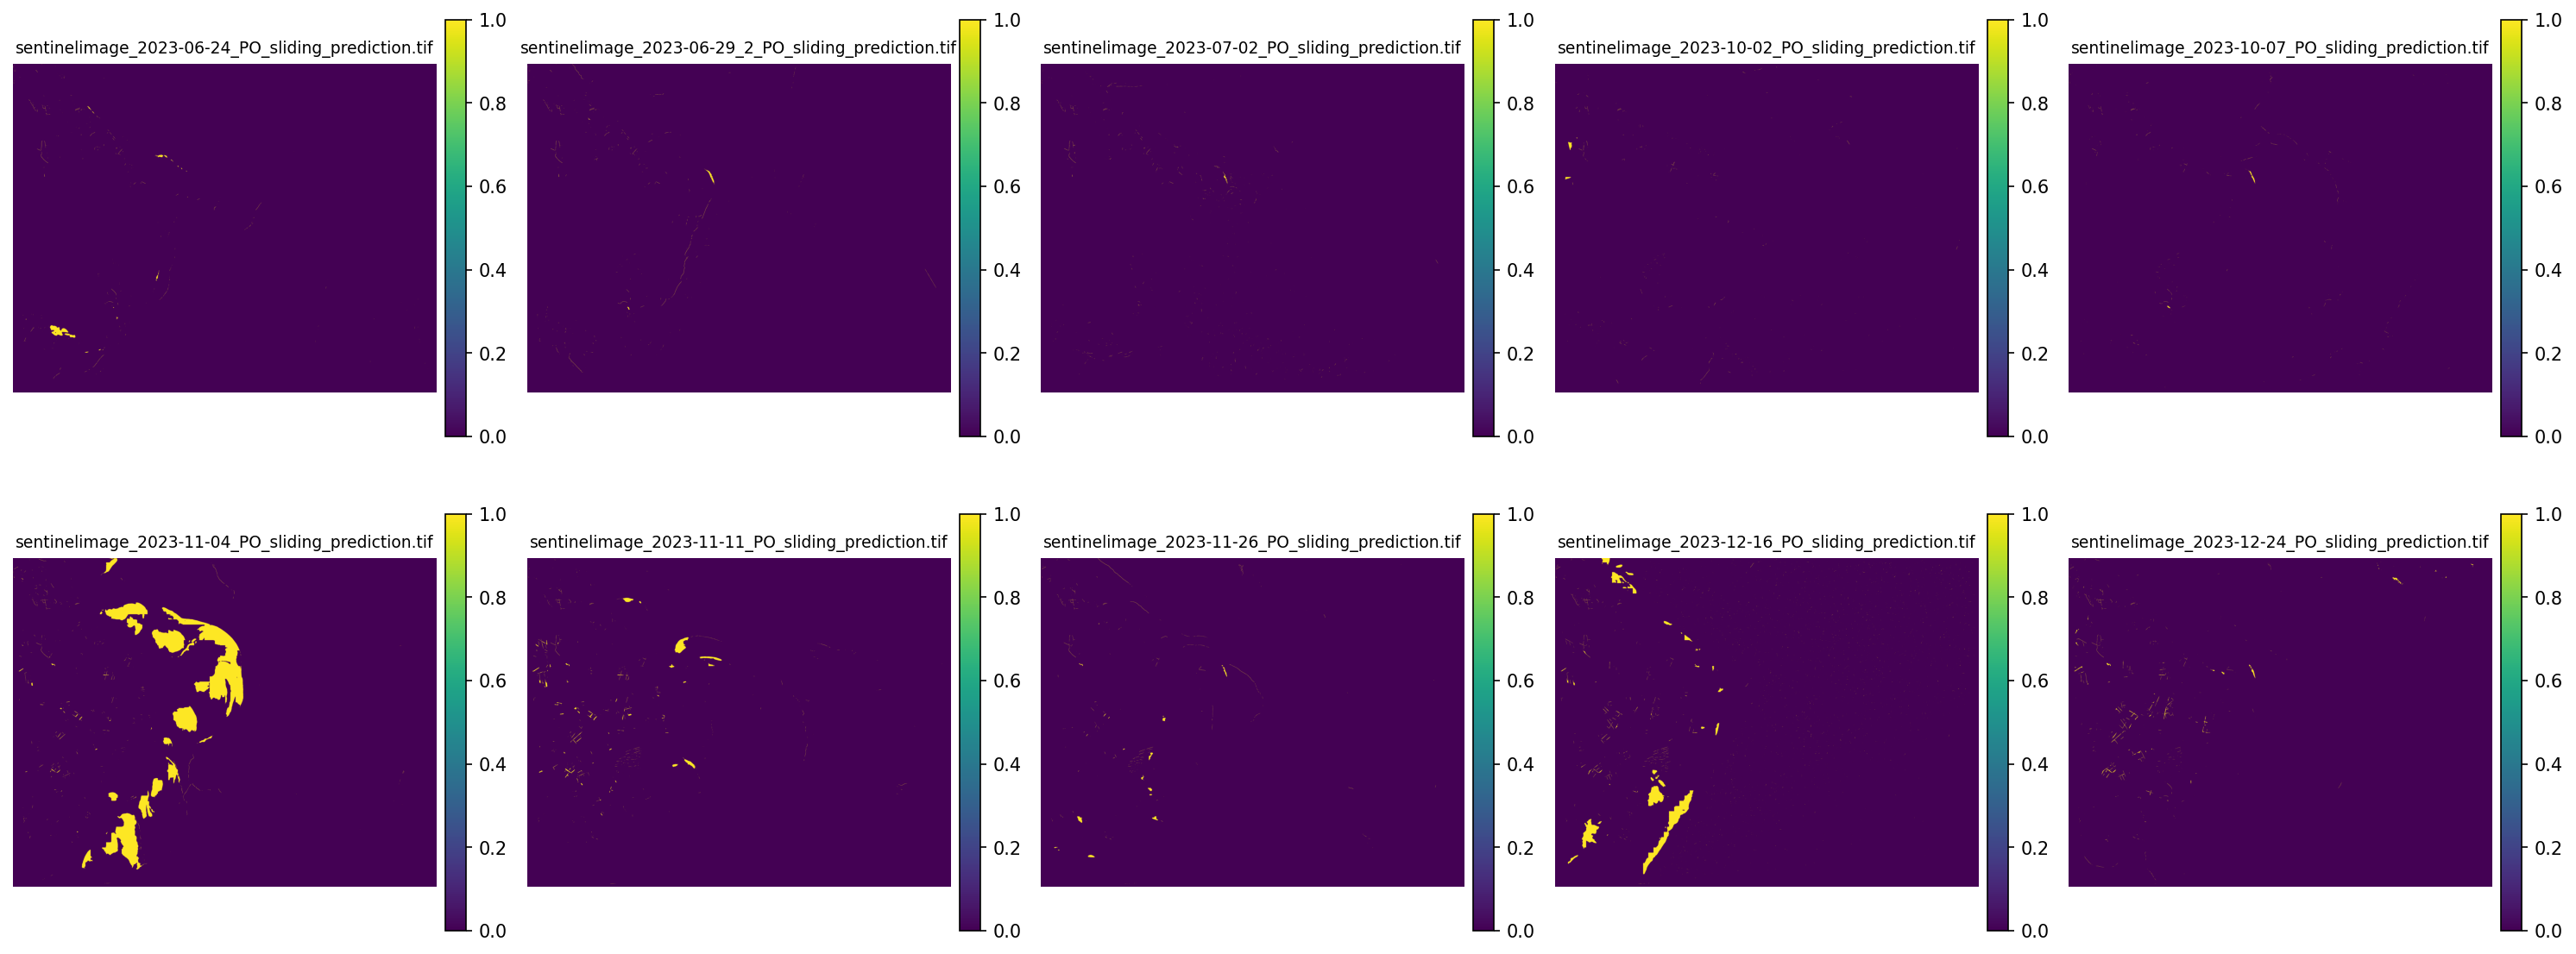

In [15]:
# Activation maps binarizedm unet++
import os
import glob
import rasterio
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt


folder = "/home/michelangelo/Sentinel_normalize"
prediction_paths = sorted(glob.glob(os.path.join(folder, "*_prediction.tif")))


all_pixels = []
for path in prediction_paths:
    with rasterio.open(path) as src:
        img = src.read(1).astype(np.float32)
    all_pixels.append(img.flatten())
all_pixels = np.concatenate(all_pixels)


global_thr = threshold_otsu(all_pixels)
print(f"\ treshold: {global_thr:.4f}\n")

binary_images = []
filenames = []
for path in prediction_paths:
    with rasterio.open(path) as src:
        img = src.read(1).astype(np.float32)
    bin_img = (img > global_thr).astype(np.uint8)
    binary_images.append(bin_img)
    filenames.append(os.path.basename(path))


n = len(binary_images)
ncols = 5
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), dpi=150)
axes = axes.flatten()

for ax, bin_img, fname in zip(axes, binary_images, filenames):
    im = ax.imshow(bin_img, cmap="viridis", vmin=0, vmax=1)
    ax.set_title(fname, fontsize=9)
    ax.axis("off")
    fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.02)


for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

Trovati 10 file pred.
Stack shape: (4069, 5238, 10) (H, W, T)


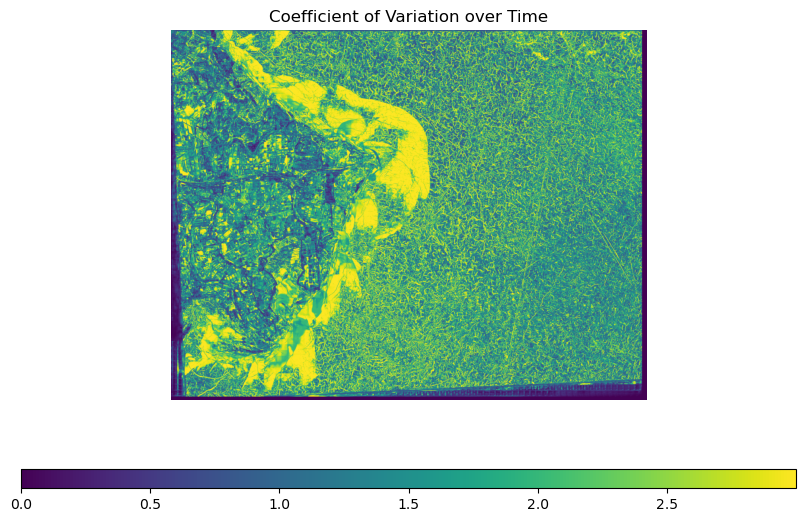

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob

input_folder = "/home/michelangelo/Sentinel_normalize"  
file_paths = sorted(glob.glob(os.path.join(input_folder, "*_prediction.tif")))

print(f"Trovati {len(file_paths)} file pred.")
assert len(file_paths) > 0, "⚠️ Nessun file *_prediction.tif trovato!"


stack = np.stack([rasterio.open(f).read(1) for f in file_paths], axis=2)
print(f"Stack shape: {stack.shape} (H, W, T)")

mean_stack = np.mean(stack, axis=2)
std_stack = np.std(stack, axis=2)


coeff_var_time = np.divide(std_stack, mean_stack,
                           out=np.zeros_like(std_stack),
                           where=mean_stack != 0)

plt.figure(figsize=(10, 6))
plt.imshow(coeff_var_time, cmap='viridis')  # nessuna normalizzazione
plt.title("Coefficient of Variation over Time")
plt.colorbar(orientation="horizontal", fraction=0.05, aspect=40)
plt.axis("off")
plt.show()

Clipping CV ai percentili 5–95: 1.061 – 2.995


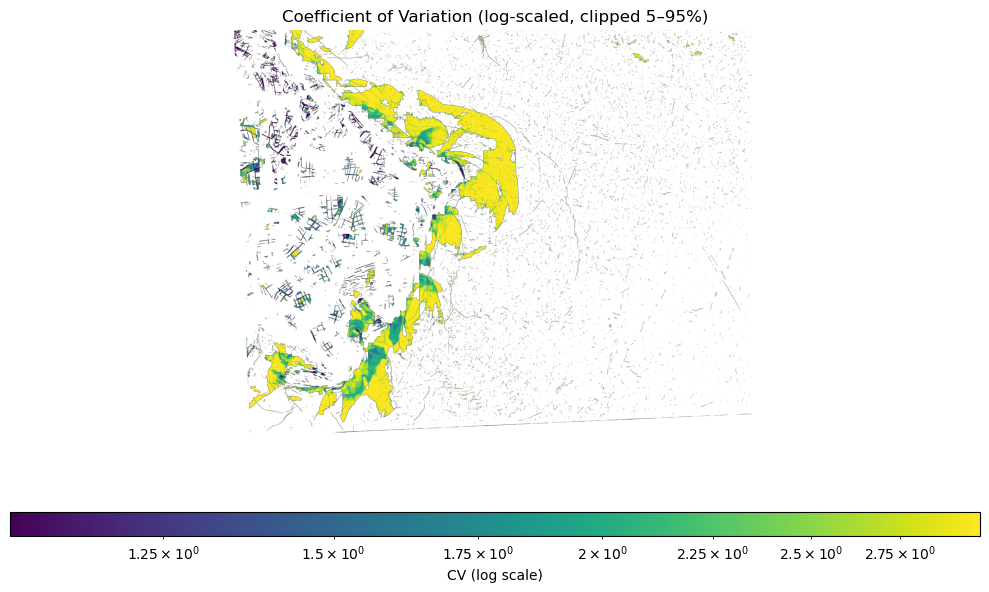

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob
from matplotlib.colors import LogNorm

# 1) Carica stack
input_folder = "/home/michelangelo/Sentinel_normalize"  
paths = sorted(glob.glob(os.path.join(input_folder, "*_prediction.tif")))
stack = np.stack([rasterio.open(p).read(1).astype(np.float32) for p in paths], axis=2)

mean_stack = stack.mean(axis=2)
std_stack  = stack.std(axis=2)
cv = np.divide(std_stack, mean_stack,
               out=np.zeros_like(std_stack),
               where=mean_stack!=0)

# 2) Mask pixel con media troppo bassa (eviti CV infiniti o rumorosi)
mean_thresh = 0.01  # aggiusta a seconda dei valori del tuo stack
cv_masked = np.ma.masked_where(mean_stack < mean_thresh, cv)

# 3a) Calcolo percentili per clipping
p5, p95 = np.percentile(cv_masked.compressed(), [5, 95])
print(f"Clipping CV ai percentili 5–95: {p5:.3f} – {p95:.3f}")

# 3b) Plotto in log (o, se preferisci, senza log basta togliere norm)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
im = ax.imshow(cv_masked + 1e-6,  # evita zero log
               cmap='viridis',
               norm=LogNorm(vmin=p5, vmax=p95))
ax.set_title("Coefficient of Variation (log-scaled, clipped 5–95%)")
ax.axis('off')

# colorbar verticale o orizzontale come vuoi:
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, aspect=40)
cbar.set_label("CV (log scale)")

plt.tight_layout()
plt.show()


In [ ]:
#Statistic on binarize prediction maps
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




# 2) Estrazione delle date dai file
dates = []
for path in all_prediction_files:
    m = re.search(r"(\d{4}-\d{2}-\d{2})", os.path.basename(path))
    dates.append(pd.to_datetime(m.group(1)) if m else pd.NaT)

# 3) Calcolo conteggi, proporzioni e accumulo stats
stats = []
for date, bm in zip(dates, binarized_prediction_maps):
    flat  = bm.ravel()
    total = flat.size
    ones  = int(flat.sum())
    zeros = total - ones
    prop1 = ones / total
    prop0 = zeros / total
    stats.append({
        "date":    date,
        "count_1": ones,
        "count_0": zeros,
        "prop_1":  prop1,
        "prop_0":  prop0
    })

# 4) DataFrame indicizzato per data
df = pd.DataFrame(stats).set_index("date").sort_index()
print(df)

# 5) Calcolo delle medie dei conteggi e delle proporzioni
mean_count1 = df["count_1"].mean()
mean_count0 = df["count_0"].mean()
mean_prop1  = df["prop_1"].mean()
mean_prop0  = df["prop_0"].mean()

print(f"\nMedia count_1: {mean_count1:.1f}, media count_0: {mean_count0:.1f}")
print(f"Media prop_1: {mean_prop1:.4f}, media prop_0: {mean_prop0:.4f}")

# 6) Plot delle proporzioni con linee orizzontali per le medie
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["prop_1"], marker="o", label="Prop. pixel=1")
plt.axhline(mean_prop1, color="C0", linestyle="--",
            label=f"Mean prop_1 = {mean_prop1:.2f}")
plt.plot(df.index, df["prop_0"], marker="s", label="Prop. pixel=0")
plt.axhline(mean_prop0, color="C1", linestyle="--",
            label=f"Mean prop_0 = {mean_prop0:.2f}")
plt.title("Shape of  proportions 1 vs 0 on the binarized prediction maps")
plt.xlabel("Data")
plt.ylabel("Pixel proportion")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show() 